<a href="https://colab.research.google.com/github/alejandro-ao/tbs-msc-projects/blob/master/Spark_Trump_Tweet_Wordclouds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1: Donald Trump Communication Analysis on Twitter 

History of Donald trump tweets: more than 58 000 tweets from 2009 
to November 19th, 2020

## SET UP 
Create the spark context and import the data

In [ ]:
# Setting up Spark environment on Google Collab
tweets_path = "drive/MyDrive/PYSPARK-COURSE/Project/trump_tweets.txt"

# installing spark on the current environment
!pip install pyspark
!pip install -q findspark
import findspark
findspark.init()

# mount your google drive to be able to access files from your google drive ! 
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pyspark
spark = pyspark.SparkContext(appName= "Tweet Analysis")

In [ ]:
# Read text file trump_tweets into a RDD
tweets = spark.textFile(tweets_path)

# Number of tweets
tweets.count()

58681

## Create wordcount for all words used in the tweets
Count the number of times each word appears

In [ ]:
# Extract the tweet without the date
tweets_text = tweets.map(lambda line: line.split(';')[0])

In [ ]:
def get_wordcount_from_tweets(tweets_text):
  """
  Arguments:
  - tweets_text (RDD) collection of tweets. Only the text, no date.

  Returs:
  - wordcounts (RDD of tuples). 
  """
  # Extract the words
  words = tweets_text.flatMap(lambda line: line.split())

  # Initialize an rdd key/value for counting each word in the file
  words_kv = words.map(lambda word: (word,1))

  # reduce by key to get counts for each word
  wordcounts = words_kv.reduceByKey(lambda x, y: y + x)
  
  return wordcounts

In [ ]:
type(get_wordcount_from_tweets(tweets_text))

pyspark.rdd.PipelinedRDD

### Positive and negative wordcounts

In [ ]:
positives_path = "drive/MyDrive/PYSPARK-COURSE/Project/positive-words.txt"
negatives_path = "drive/MyDrive/PYSPARK-COURSE/Project/negative-words.txt"

positive_words = spark.textFile(positives_path)
negative_words = spark.textFile(negatives_path)

In [ ]:
def get_counts_from_dict(dictionary, tweets_text):

  # Initialize an rdd with key/value to count words in the dictionary
  dictionary_kv = dictionary.map(lambda word: (word,1))

  # Extract the words from tweets and crate KV pairs
  words = tweets_text.flatMap(lambda line: line.split())
  words_kv = words.map(lambda word: (word,1))

  # join (inner join) tweet words with dict words and reset tuple value
  dict_tweet_words = words_kv.join(dictionary_kv)
  dict_tweet_words = dict_tweet_words.mapValues(lambda value:1)

  # Count the occurences of the dict words and sort in descending order
  dict_wordcount = dict_tweet_words\
                    .reduceByKey(lambda a,b: a+b)\
                    .sortBy(lambda tuple:tuple[1], ascending=False)

  return dict_wordcount


In [ ]:
wordcount_pos = get_counts_from_dict(positive_words, tweets_text)
wordcount_pos.take(5)

[('great', 3902), ('like', 1744), ('good', 1186), ('best', 868), ('love', 825)]

In [ ]:
wordcount_neg = get_counts_from_dict(negative_words, tweets_text)
wordcount_neg.take(5)

[('bad', 671),
 ('hard', 577),
 ('lost', 293),
 ('illegal', 293),
 ('terrible', 259)]

## Create word clouds for positive and negative words (and hashtags)

In [ ]:
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

ss = pyspark.sql.SparkSession(spark)

def wordcloud_from_wordcount(rdd_wordcount):
  """
  Creates a wordcloud from an RDD of key-value pairs. 
  Parameters:
    rdd_wordcount (Spark.RDD): key-value pairs of wordcounts
  Output:
    Wordcloud graphic  
  """
  schema = StructType([StructField("word",StringType(),False),
                     StructField("frequency",IntegerType(),False)])
  
  words_df = ss.createDataFrame(rdd_wordcount, schema)

  words_to_plot = rdd_wordcount.take(100) # list
  word_cloud = WordCloud(background_color='white').generate_from_frequencies(dict(words_to_plot))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()


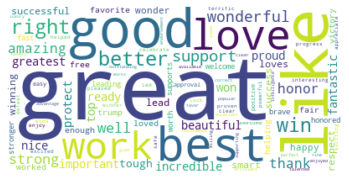

In [ ]:
# for positive words
wordcloud_from_wordcount(wordcount_pos)

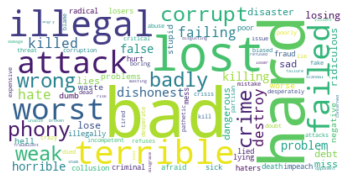

In [ ]:
# for negative words
wordcloud_from_wordcount(wordcount_neg)

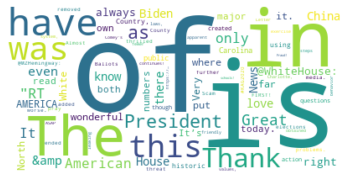

In [ ]:
# for all words (todo: remove stopwords)
wordcount_all = get_wordcount_from_tweets(tweets_text)
wordcloud_from_wordcount(wordcount_all)

In [ ]:
import re

# Use regular expression to filter out words starting with "#"
rdd_hashtags = rdd_tweet_word.filter(lambda word: re.match(r"^#", word))

# Count the occurences of hashtags and sort in descending order
rdd_hashtag_count = rdd_hashtags.map(lambda hashtag: (hashtag, 1))\
                                .reduceByKey(lambda a, b: a + b)\
                                .sortBy(lambda tuple: tuple[1], ascending=False)

# Print the top 10 hashtags
rdd_hashtag_count.take(10)

[('#Trump2016', 434),
 ('#MAGA', 414),
 ('#MakeAmericaGreatAgain', 281),
 ('#CelebApprentice', 220),
 ('#Trump2016"""""""', 170),
 ('#1', 110),
 ('#CelebrityApprentice', 83),
 ('#MakeAmericaGreatAgain"""""""', 71),
 ('#AmericaFirst', 65),
 ('#KAG2020', 63)]

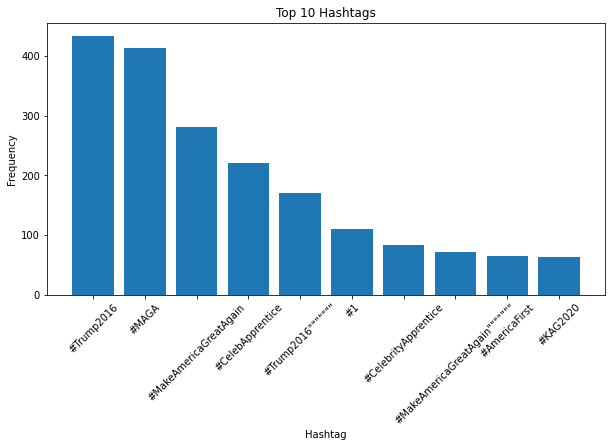

In [ ]:
import matplotlib.pyplot as plt

# Extract the top 10 hashtags and their frequency
top_hashtags = rdd_hashtag_count.take(10)
hashtags = [x[0] for x in top_hashtags]
frequency = [x[1] for x in top_hashtags]

# Create a tree chart
plt.figure(figsize=(10,5))
plt.bar(hashtags, frequency)
plt.xlabel("Hashtag")
plt.ylabel("Frequency")
plt.title("Top 10 Hashtags")
plt.xticks(rotation=45)
plt.show()